In [45]:
%reset -sf

import sys
sys.path.insert(0, '../..')
import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp

import os

from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_memory_growth(gpus[1], True)
print(tf.__version__)
print(tf.config.list_physical_devices(), end='\n\n')

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [46]:
SEED = 42  # set random seed (global variable)
np.random.seed(SEED)
processor = gd.DataProcessor()
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 128

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [47]:
## Global variables

GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

w_lead shape: (2928862, 9)
               E            px            py             pz             m  \
0  114813.382812 -16190.328125  63319.132812   50221.468750  79927.953125   
1  450737.750000  70425.804688   3821.072266  438394.468750  77462.359375   
2  102566.046875 -10254.437500  45208.792969   79655.101562  45009.675781   

             pt       eta       phi         y  
0  65356.249165  0.707823  1.821127  0.469034  
1  70529.387911  2.526646  0.054204  2.138567  
2  46357.183371  1.310057  1.793846  1.036803  
                  E            px            py            pz             m  \
count  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06  2.928862e+06   
mean   2.283278e+05 -1.788823e+01  1.700620e+01  2.688194e+02  7.062466e+04   
std    2.440128e+05  3.510948e+04  3.504798e+04  3.222953e+05  1.877761e+04   
min    1.596886e+04 -1.474598e+06 -7.555793e+05 -4.386726e+06  2.000148e+03   
25%    9.528028e+04 -1.782399e+04 -1.778516e+04 -1.062248e+05  7.283715e+04  

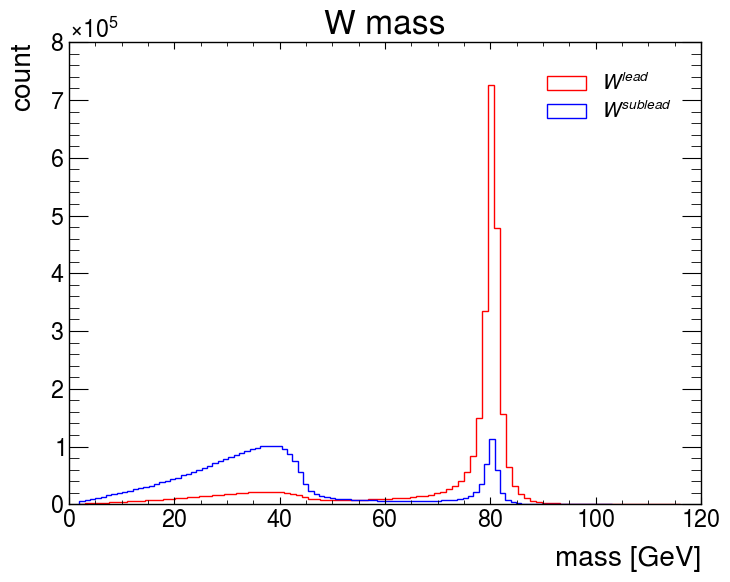

In [48]:
## Interesting variables

# Critria for leading and subleading lepton
lead_p = data.LeadLep["m"] == data.LepP["m"]
sublead_p = ~lead_p
lead_m = sublead_p.copy()
sublead_m = lead_p.copy()

# (sub)lead W
w_lead = pd.concat([data.Wp[lead_p], data.Wm[lead_m]], axis=0).sort_index()
w_sublead = pd.concat([data.Wp[sublead_p], data.Wm[sublead_m]], axis=0).sort_index()
print("w_lead shape:", w_lead.shape)
print(w_lead.head(3))
print(w_lead.describe())

# Check (sub)lead W
plt.hist(w_lead["m"] / GEV, bins=100, color="r", histtype="step", label=r"$W^{lead}$")
plt.hist(
    w_sublead["m"] / GEV, bins=100, color="b", histtype="step", label=r"$W^{sublead}$"
)
plt.title("W mass")
plt.xlabel("mass [GeV]")
plt.ylabel("count")
plt.legend(loc="best")
plt.show()
plt.close()

# Kinematics of interesting variables (target for training)
int_kin_e = w_lead[["E"]][PRE_CUT] / GEV
int_kin_px = w_lead[["px"]][PRE_CUT] / GEV
int_kin_py = w_lead[["py"]][PRE_CUT] / GEV
int_kin_pz = w_lead[["pz"]][PRE_CUT] / GEV

MINMAX_INT_E = MinMaxScaler()
int_kin_e = MINMAX_INT_E.fit_transform(int_kin_e)
MINMAX_INT_PX = MinMaxScaler()
int_kin_px = MINMAX_INT_PX.fit_transform(int_kin_px)
MINMAX_INT_PY = MinMaxScaler()
int_kin_py = MINMAX_INT_PY.fit_transform(int_kin_py)
MINMAX_INT_PZ = MinMaxScaler()
int_kin_pz = MINMAX_INT_PZ.fit_transform(int_kin_pz)

In [49]:
## Observing variables

met = data.MET[["px", "py"]]
lead_lep = data.LeadLep[["E", "px", "py", "pz"]]
sublead_lep = data.SubLep[["E", "px", "py", "pz"]]

# Kinematics of observing variables (inputs for training)
obs_kin = pd.concat([lead_lep, sublead_lep, met], axis=1)[PRE_CUT] / GEV
print("int_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array
STDSCALAR_OBS = StandardScaler()
obs_kin = STDSCALAR_OBS.fit_transform(obs_kin)
print(type(obs_kin))

int_kin shape: (1378510, 10)
             E         px         py          pz          E         px  \
7    43.361348  42.407754  -4.632000    7.767462  19.500895  -4.561588   
9   164.814766  34.397141   2.031300 -161.172625  70.592648  29.001777   
10   90.238664 -23.868604  32.986602   80.530680  47.669113 -26.605045   

           py         pz         px         py  
7   18.924410  -1.154271  96.335650  47.095450  
9    1.896990 -64.332027 -26.992604 -70.883859  
10 -17.256748  35.590859  44.222846 -15.383637  
                  E            px            py            pz             E  \
count  1.378510e+06  1.378510e+06  1.378510e+06  1.378510e+06  1.378510e+06   
mean   1.228232e+02 -2.283103e-02  2.369144e-02  1.919805e-01  7.518447e+01   
std    1.474662e+02  3.340791e+01  3.335215e+01  1.860197e+02  9.723482e+01   
min    2.200140e+01 -6.775440e+02 -5.162718e+02 -2.858096e+03  1.500272e+01   
25%    4.539499e+01 -2.507789e+01 -2.505726e+01 -5.382219e+01  2.680265e+01   
50% 

In [50]:
np.random.seed(SEED)
sample = np.random.choice(obs_kin.shape[0], int(1e5), replace=False)
sample_int_e = int_kin_e[sample]
sample_int_px = int_kin_px[sample]
sample_int_py = int_kin_py[sample]
sample_int_pz = int_kin_pz[sample]
sample_obs = obs_kin[sample]

In [51]:
# load models
px_model = tf.keras.models.load_model("./dnn_w_lead_px_scaled.h5")
py_model = tf.keras.models.load_model("./dnn_w_lead_py_scaled.h5")
pz_model = tf.keras.models.load_model("./dnn_w_lead_pz_scaled.h5")
e_model = tf.keras.models.load_model("./dnn_w_lead_e_scaled.h5")

In [52]:
# predic data
px_pred = px_model.predict(sample_obs)
py_pred = py_model.predict(sample_obs)
pz_pred = pz_model.predict(sample_obs)
e_pred = e_model.predict(sample_obs)

3125/3125 [==============================] - 4s 1ms/step


In [58]:
def check(transfomer, true, pred, var, range):
    sig_truth_inv = transfomer.inverse_transform(true).flatten()
    sig_pred_inv = transfomer.inverse_transform(pred).flatten()
    print(
        f"Truth mean: {np.mean(sig_truth_inv):.3f}, std: {np.std(sig_truth_inv):.3f}, min: {np.min(sig_truth_inv):.3f}, max: {np.max(sig_truth_inv):.3f}"
    )
    plot.hist(
        data=[sig_truth_inv, sig_pred_inv],
        label=var,
        title="Leading "
        + var,
        # + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv, sig_pred_inv)):.3f}",
        range=range,
        unit="[GeV]",
    )

Truth mean: 227.309, std: 241.455, min: 25.754, max: 3478.761


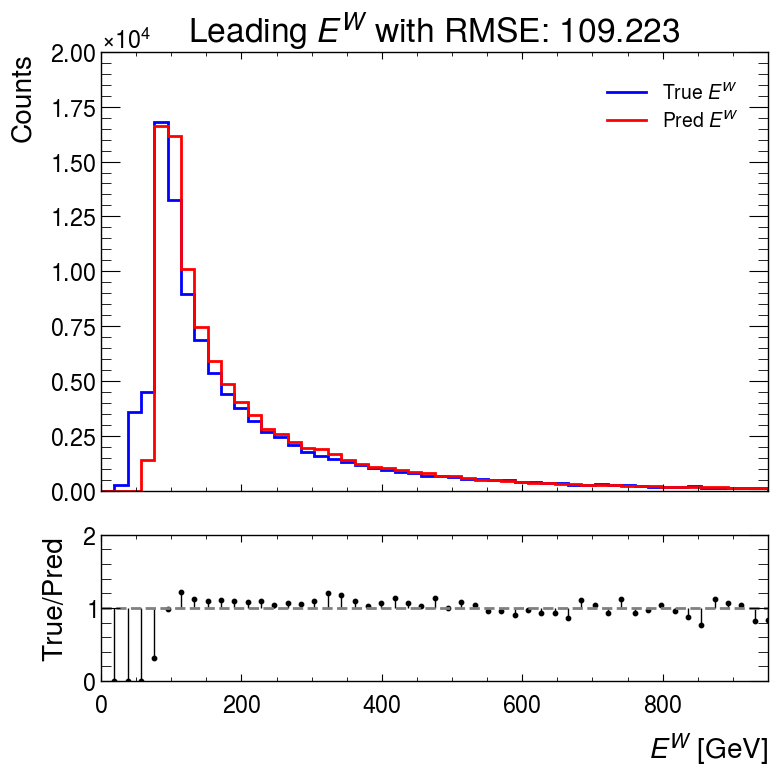

Truth mean: -0.109, std: 37.126, min: -486.789, max: 554.443


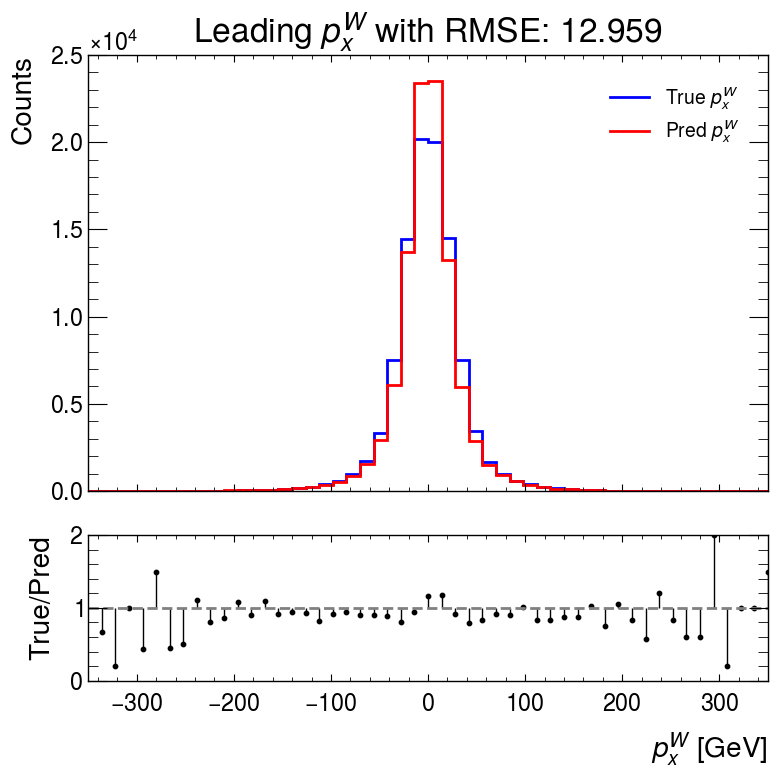

Truth mean: -0.164, std: 37.009, min: -440.601, max: 573.168


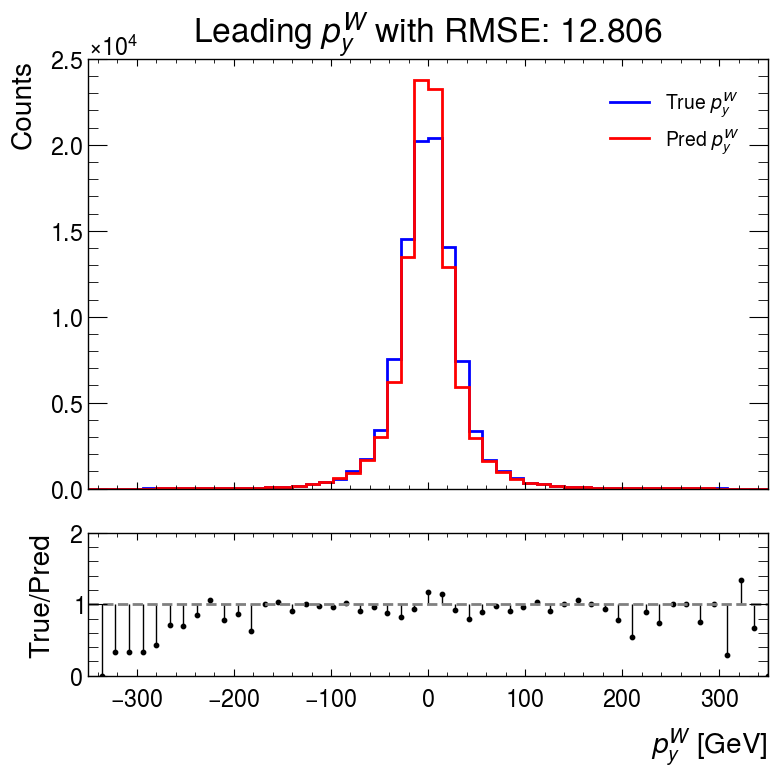

Truth mean: 1.611, std: 319.346, min: -3473.245, max: 3477.601


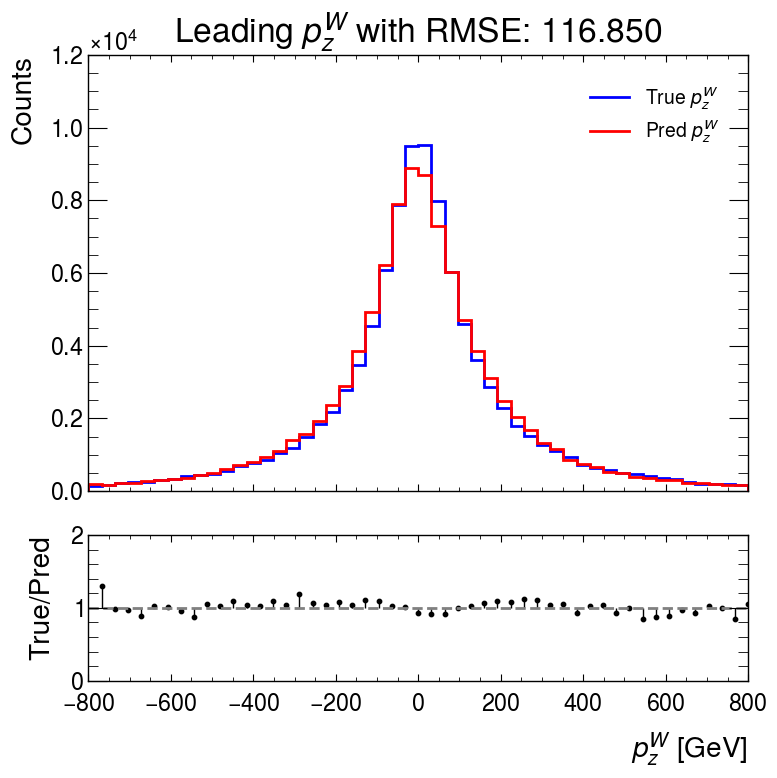

In [59]:
check(MINMAX_INT_E, sample_int_e, e_pred, r"$E^{W}$", (0, 950))
check(MINMAX_INT_PX, sample_int_px, px_pred, r"$p_{x}^{W}$", (-350, 350))
check(MINMAX_INT_PY, sample_int_py, py_pred, r"$p_{y}^{W}$", (-350, 350))
check(MINMAX_INT_PZ, sample_int_pz, pz_pred, r"$p_{z}^{W}$", (-800, 800))

In [60]:
def w_mass(e, px, py, pz):
    e = MINMAX_INT_E.inverse_transform(e).flatten()
    px = MINMAX_INT_PX.inverse_transform(px).flatten()
    py = MINMAX_INT_PY.inverse_transform(py).flatten()
    pz = MINMAX_INT_PZ.inverse_transform(pz).flatten()
    momenta = [px, py, pz]
    p_all = np.sqrt(np.sum([np.square(p) for p in momenta], axis=0))
    mask = np.square(e) >= np.square(p_all)
    return np.sqrt(np.square(e[mask]) - np.square(p_all[mask]))

In [61]:
w_mass_true = w_mass(sample_int_e, sample_int_px, sample_int_py, sample_int_pz)
w_mass_pred = w_mass(e_pred, px_pred, py_pred, pz_pred)

Text(0.5, 1.0, 'W mass comparison')

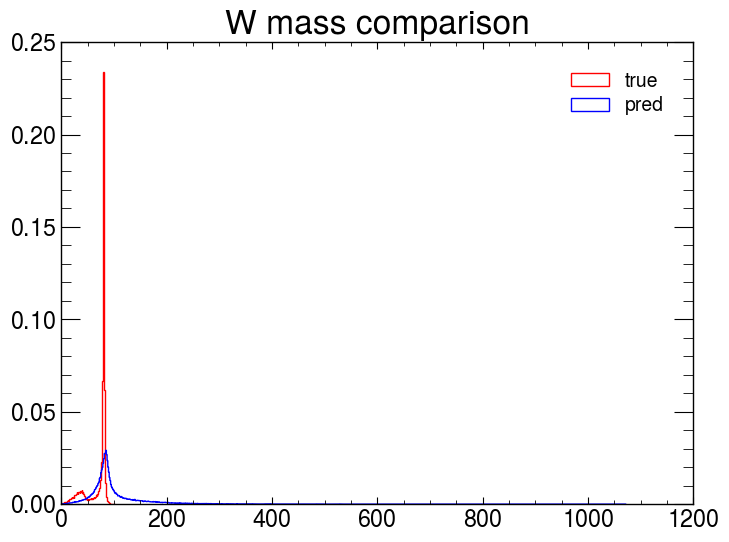

In [74]:
bins, _, _ = plt.hist(
    w_mass_true,
    bins=200,
    color="r",
    histtype="step",
    label="true",
    density=True,
)
bins, _, _ = plt.hist(
    w_mass_pred,
    bins=800,
    color="b",
    histtype="step",
    label="pred",
    density=True,
)
plt.legend(loc="best")
plt.title("W mass comparison")
# plt.xlim([0, 300])